# Parte 2 del concurso de detección de clickbait

5. Usar Lora para el ajuste de hiperparámetros optimizado.

In [1]:
%pip install transformers[torch]
%pip install peft==0.6.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## Importar bibliotecas

In [2]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch.utils.data import Dataset
import csv
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter
from peft import LoraConfig, get_peft_model

## Cargar datasets

In [3]:
df_train = pd.read_csv('TA1C_dataset_detection_train.csv')
df_train = df_train.drop(['Tweet Date', 'Media Name', 'Media Origin'], axis=1)

df_dev = pd.read_csv('TA1C_dataset_detection_dev_gold.csv')
df_dev = df_dev.drop(['Tweet Date', 'Media Name', 'Media Origin'], axis=1)

## Definir datasets de prueba y de dev

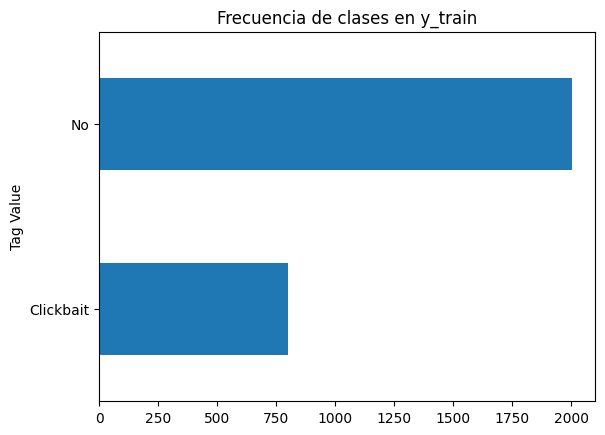

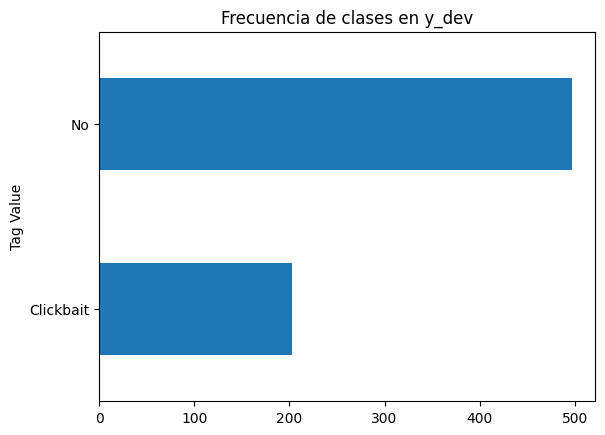

In [4]:
# Separar dataset
X_train = df_train['Teaser Text']
y_train = df_train['Tag Value']

X_dev = df_dev['Teaser Text']
y_dev = df_dev['Tag Value']

le = LabelEncoder()
y_train_labels = le.fit_transform(y_train)
y_dev_labels = le.transform(y_dev)

y_train.value_counts(ascending=True).plot.barh()
plt.title("Frecuencia de clases en y_train")
plt.show()

y_dev.value_counts(ascending=True).plot.barh()
plt.title("Frecuencia de clases en y_dev")
plt.show()


## Carga del modelo

In [5]:
tokenizer = RobertaTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-base-bne')

train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
dev_encodings = tokenizer(X_dev.tolist(), truncation=True, padding=True)

class CustomDataset(Dataset):
  def __init__(self, encodings, labels):
    self.encodings=encodings
    self.labels=labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = CustomDataset(train_encodings, y_train_labels)
dev_dataset = CustomDataset(dev_encodings, y_dev_labels)

config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        bias="none",
        task_type="SEQ_CLS"
    )

model = RobertaForSequenceClassification.from_pretrained('PlanTL-GOB-ES/roberta-base-bne', num_labels=2)
model = get_peft_model(model, config)
model.print_trainable_parameters() # Para ver cuántos parámetros son entrenables ahora

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 887,042 || all params: 125,531,908 || trainable%: 0.7066267167706874


In [6]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="macro")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [7]:
training_args = TrainingArguments(
    output_dir="output",
    eval_strategy="steps",
    eval_steps=100,
    num_train_epochs=10,
    seed=0,
    load_best_model_at_end=True,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: omarveco (omarveco-instituto-polit-cnico-nacional) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1
100,No log,0.571667,0.710000,0.415205
200,No log,0.481744,0.755714,0.608771
300,No log,0.358908,0.837143,0.786080
400,No log,0.269517,0.897143,0.871643
500,0.446400,0.281102,0.891429,0.857906
600,0.446400,0.254064,0.907143,0.882416
700,0.446400,0.241430,0.912857,0.891426
800,0.446400,0.242207,0.915714,0.896281
900,0.446400,0.243417,0.914286,0.895000
1000,0.263600,0.257032,0.912857,0.888911


TrainOutput(global_step=3500, training_loss=0.23759180341448102, metrics={'train_runtime': 328.9356, 'train_samples_per_second': 85.123, 'train_steps_per_second': 10.64, 'total_flos': 1599169978560000.0, 'train_loss': 0.23759180341448102, 'epoch': 10.0})

## Predicción en el conjunto de prueba

### Cargar dataset de testeo

In [8]:
df_test = pd.read_csv('TA1C_dataset_detection_dev_gold.csv')
df_test = df_test.drop(['Tweet Date', 'Media Name', 'Media Origin'], axis=1)

X_test = df_test['Teaser Text']
y_test = df_test['Tag Value']

test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)
y_test_labels = le.transform(y_test)

test_dataset = CustomDataset(test_encodings, y_test_labels)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = trainer.predict(test_dataset)

predicted_classes = np.argmax(predictions.predictions, axis=1)

report = classification_report(y_test_labels, predicted_classes)

print(report)


              precision    recall  f1-score   support

           0       0.89      0.83      0.86       203
           1       0.93      0.96      0.95       497

    accuracy                           0.92       700
   macro avg       0.91      0.89      0.90       700
weighted avg       0.92      0.92      0.92       700



In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Matriz de confusión normalizada")
  plt.show()

[0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 

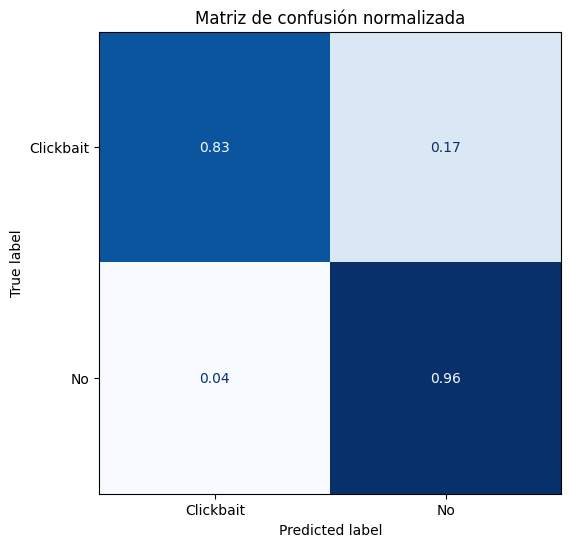

In [11]:
import numpy as np

label_name = np.unique(df_test['Tag Value'])
y_test = y_test_labels.tolist()
print(y_test)
plot_confusion_matrix(predicted_classes, y_test, label_name)

## Generar detection.csv

### Cargar csv

In [13]:
df_detect = pd.read_csv('TA1C_dataset_detection_test.csv')
df_detect = df_detect.drop(['Tweet Date', 'Media Name', 'Media Origin'], axis=1)

X_detect = df_detect['Teaser Text']

detect_encodings = tokenizer(X_detect.tolist(), truncation=True, padding=True)

class CustomDatasetNoLabels(Dataset):
  def __init__(self, encodings):
    self.encodings=encodings

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    return item

  def __len__(self):
    return len(self.encodings['input_ids'])

detect_dataset = CustomDatasetNoLabels(detect_encodings)

predictions_detect = trainer.predict(detect_dataset)

predicted_classes_detect = np.argmax(predictions_detect.predictions, axis=1)

predicted_labels_detect = le.inverse_transform(predicted_classes_detect)

df_detect['Tag Value'] = predicted_labels_detect

df_detect = df_detect.drop(['Teaser Text'], axis=1)

df_detect.to_csv('detection.csv', index=False)